<a href="https://colab.research.google.com/github/LapTQ/surface_defect_detection/blob/main/surface_defect_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Datasets:
* Detection
 * [Steel Surface: NEU-CLS](http://faculty.neu.edu.cn/songkc/en/zdylm/263265/list/index.htm)
 * [DeepPBC](https://github.com/Charmve/Surface-Defect-Detection/tree/master/DeepPCB)
* Segmenation
 * [Severstal: Steel Defect Detection](https://www.kaggle.com/c/severstal-steel-defect-detection/overview)
 * [AITEX FABRIC IMAGE DATABASE](https://www.aitex.es/afid/)

* EDA
* algorithms to detect ROI then classify (2 stages): faster RCNN, seam carving, interest points,...
* classify then detect ROI: saliency map
* compare to papers with the same dataset

https://towardsdatascience.com/i-performed-error-analysis-on-open-images-and-now-i-have-trust-issues-89080e03ba09

https://stackoverflow.com/questions/67244258/how-to-get-class-and-bounding-box-coordinates-from-yolov5-predictions

https://docs.ultralytics.com/tutorials/pytorch-hub/

In [1]:
!git clone https://github.com/LapTQ/surface_defect_detection.git
!git clone https://github.com/ultralytics/yolov5
# !pip install -r yolov5/requirements.txt

Cloning into 'surface_defect_detection'...
remote: Enumerating objects: 3706, done.
remote: Counting objects: 100% (3706/3706), done.
remote: Compressing objects: 100% (1992/1992), done.
remote: Total 3706 (delta 1765), reused 3603 (delta 1710), pack-reused 0
Receiving objects: 100% (3706/3706), 26.32 MiB | 31.74 MiB/s, done.
Resolving deltas: 100% (1765/1765), done.
Cloning into 'yolov5'...
remote: Enumerating objects: 11327, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 11327 (delta 5), reused 13 (delta 5), pack-reused 11314
Receiving objects: 100% (11327/11327), 11.22 MiB | 22.84 MiB/s, done.
Resolving deltas: 100% (7823/7823), done.


In [2]:
import torch
import tensorflow as tf
from IPython.display import Image
import os
import sys
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from pathlib import Path
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print('torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

torch 1.10.0+cu111 CPU


## EDA

In [5]:
print('[INFO] number of xml files:', len(list(Path('surface_defect_detection/NEU-DET/ANNOTATIONS').glob('*.xml'))))
print('[INFO] number of images (.jpg) files:', len(list(Path('surface_defect_detection/NEU-DET/IMAGES').glob('*.jpg'))))

[INFO] number of xml files: 1800
[INFO] number of images (.jpg) files: 1800


In [31]:
# show an example
!cat surface_defect_detection/NEU-DET/ANNOTATIONS/crazing_2.xml

<annotation>
	<folder>cr</folder>
	<filename>crazing_2.jpg</filename>
	<source>
		<database>NEU-DET</database>
	</source>
	<size>
		<width>200</width>
		<height>200</height>
		<depth>1</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>crazing</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>99</xmin>
			<ymin>120</ymin>
			<xmax>200</xmax>
			<ymax>174</ymax>
		</bndbox>
	</object>
	<object>
		<name>crazing</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>8</xmin>
			<ymin>16</ymin>
			<xmax>200</xmax>
			<ymax>111</ymax>
		</bndbox>
	</object>
</annotation>


In [3]:
def extract_info_from_xml(xml_file):
    """Read xml file and extract information.
    Arguments:
        xml_file - path to the xml file.
    Return a dictionary containing info.
    """
    xml_root = ET.parse(xml_file).getroot()

    info = {}
    info['bboxes'] = []
    
    for element in xml_root:
        # get image file name
        if element.tag == 'filename':
            info['filename'] = element.text

        # get image size
        if element.tag == 'size':
            image_size = []
            for sub_element in element:
                info['image_' + sub_element.tag] = int(sub_element.text)
        
        # get bounding boxes
        if element.tag == 'object':
            bbox = {}
            for sub_element in element:
                if sub_element.tag == 'name':
                    bbox['class'] = sub_element.text
                elif sub_element.tag == 'bndbox':
                    for sub_sub_element in sub_element:
                        bbox[sub_sub_element.tag] = int(sub_sub_element.text)
            info['bboxes'].append(bbox)
    return info

In [4]:
extract_info_from_xml('surface_defect_detection/NEU-DET/ANNOTATIONS/crazing_2.xml')

{'bboxes': [{'class': 'crazing',
   'xmax': 200,
   'xmin': 99,
   'ymax': 174,
   'ymin': 120},
  {'class': 'crazing', 'xmax': 200, 'xmin': 8, 'ymax': 111, 'ymin': 16}],
 'filename': 'crazing_2.jpg',
 'image_depth': 1,
 'image_height': 200,
 'image_width': 200}

In [4]:
class_name_to_id_mapping = {
    'crazing': 0, 
    'inclusion': 1, 
    'patches': 2, 
    'pitted_surface': 3,
    'rolled-in_scale': 4,
    'scratches': 5
}
class_id_to_name_mapping = {class_id: class_name for class_name, class_id in class_name_to_id_mapping.items()}
class_id_to_name_mapping

{0: 'crazing',
 1: 'inclusion',
 2: 'patches',
 3: 'pitted_surface',
 4: 'rolled-in_scale',
 5: 'scratches'}

In [5]:
!mkdir dataset
!mkdir dataset/labels
!cp -r surface_defect_detection/NEU-DET/IMAGES /content/dataset/images

In [6]:
def convert_to_yolov5(info):
    """Convert extracted info into yolov5 required format and save it in a new labels directory.
    Argument:
        info - Python dictionary. Eg:
            {
            'bboxes': [
                        {'class': 'crazing', 'xmax': 200, 'xmin': 99, 'ymax': 174, 'ymin': 120},
                        {'class': 'crazing', 'xmax': 200, 'xmin': 8, 'ymax': 111, 'ymin': 16}
                      ],
            'filename': 'crazing_2.jpg',
            'image_size': (200, 200, 1)
            }
    => converted as: class_id x y w h
        0 0.747500 0.735000 0.505000 0.270000
        0 0.520000 0.317500 0.960000 0.475000

    """
    buffer = []

    for bbox in info['bboxes']:
        try:
            class_id = class_name_to_id_mapping[bbox['class']]
        except KeyError:
            print('Invalid class. Must be one from', class_name_to_id_mapping)

        # convert to [x, y, w, h]
        bx = (bbox['xmin'] + bbox['xmax']) / 2
        by = (bbox['ymin'] + bbox['ymax']) / 2
        bw = (bbox['xmax'] - bbox['xmin'])
        bh = (bbox['ymax'] - bbox['ymin'])

        # normalize bbox dimensions
        bx /= info['image_width']
        by /= info['image_height']
        bw /= info['image_width']
        bh /= info['image_height']

        buffer.append('{} {:3f} {:3f} {:3f} {:3f}'.format(class_id, bx, by, bw, bh))
    
    # store in .txt file
    save_filename = os.path.join('dataset/labels', info['filename'].replace('.jpg', '') + '.txt')
    print('\n'.join(buffer), file=open(save_filename, 'w'))
    return {'class_id': class_id,
            'bx': bx,
            'by': by,
            'bw': bw,
            'bh': bh}

In [7]:
# Extract info from .xml files and save in .txt files
for ann in Path('surface_defect_detection/NEU-DET/ANNOTATIONS').glob('*.xml'):
    info = extract_info_from_xml(ann)
    convert_to_yolov5(info)

In [8]:
# check for any missing
assert len(list(Path('dataset/labels').glob('*.txt'))) == len(list(Path('surface_defect_detection/NEU-DET/ANNOTATIONS').glob('*.xml'))), "Missing some .txt files"
assert len(list(Path('dataset/images').glob('*.jpg'))) == len(list(Path('surface_defect_detection/NEU-DET/IMAGES').glob('*.jpg'))), "Missing some images"

In [6]:
# # extract info from annotation folder and store in a Dataframe
# info_list = []
# for xml_path in Path('surface_defect_detection/NEU-DET/ANNOTATIONS').glob('*.xml'):
#     info = extract_info_from_xml(xml_path)
#     for bbox in info['bboxes']:
#         info_list.append(
#             {'image_width': info['image_width'],
#              'image_height': info['image_height'],
#              'image_depth': info['image_depth'],
#              'filename': info['filename'],
#              'class': bbox['class'],
#              'xmin': bbox['xmin'],
#              'ymin': bbox['ymin'],
#              'xmax': bbox['xmax'],
#              'ymax': bbox['ymax'],
#             #  'bbox_x': (bbox['xmin'] + bbox['xmax']) / 2,
#             #  'bbox_y': (bbox['ymin'] + bbox['ymax']) / 2,
#             #  'bbox_width': (bbox['xmax'] - bbox['xmin']),
#             #  'bbox_height': (bbox['ymax'] - bbox['ymin'])
#              }
#         )

# info_df = pd.DataFrame.from_dict(info_list)
# info_df

,image_width,image_height,image_depth,filename,class,xmin,ymin,xmax,ymax
0,200,200,1,scratches_267.jpg,scratches,1,141,119,160
1,200,200,1,scratches_267.jpg,scratches,113,181,198,196
2,200,200,1,scratches_256.jpg,scratches,1,90,199,124
3,200,200,1,patches_162,patches,22,109,101,196
4,200,200,1,patches_86.jpg,patches,40,37,145,150
...,...,...,...,...,...,...,...,...,...
4184,200,200,1,patches_252.jpg,patches,121,163,176,200
4185,200,200,1,patches_252.jpg,patches,19,150,62,197
4186,200,200,1,patches_20,patches,56,1,115,191
4187,200,200,1,crazing_58.jpg,crazing,3,134,189,198


In [ ]:
# print("[INFO] number of images:", len(info_df['filename'].unique()))
# print("[INFO] image size: ({}, {}, {})".format(info_df['image_width'].unique()[0], info_df['image_height'].unique()[0], info_df['image_depth'].unique()[0]))
# info_df.groupby('class')['class'].count().plot.bar(ylabel='number of object', rot=15)

# # info_df['x'] = (info_df['xmin'] + info_df['xmax']) / 2
# # info_df['y'] = (info_df['ymin'] + info_df['ymax']) / 2
# info_df['w'] = (info_df['xmax'] - info_df['xmin'])
# info_df['h'] = (info_df['ymax'] - info_df['ymin'])

# colors = {
#     'crazing': (0, 0, 1),
#     'inclusion': (0, 1, 0),
#     'patches': (1, 0, 0),
#     'pitted_surface': (1, 1, 0),
#     'rolled-in_scale': (1, 0, 1),
#     'scratches': (0, 1, 1)
# }
# plt.figure(figsize=(15, 15))
# ax = plt.gca()
# for index in info_df.index:
#     patch = plt.Rectangle([100 - info_df.iloc[index]['w']/2, 100 - info_df.iloc[index]['h']/2], info_df.iloc[index]['w'], info_df.iloc[index]['h'],
#                           fill=False, edgecolor=colors[info_df.iloc[index]['class']], linewidth=1)
#     ax.add_patch(patch)
# plt.ylim([0, 200])
# plt.xlim([0, 200])
# plt.show()


In [12]:
def plot_bbox(image, annotation_list):
    """
    Arguments:
        image - PIL Image object
        annotation_list - Python list object containing bboxes [[bx, by, bw, bh], [...], ...] for an image
    """
    annotations = np.array(annotation_list)
    w, h = image.size

    plt.imshow(image)

    plotted_img = ImageDraw.Draw(image)

    # convert [bx, by, bw, bh] to actual size in pixel [x, y, w, h]
    transformed_ann = np.copy(annotations)
    transformed_ann[:, [1, 3]] = annotations[:, [1, 3]] * w
    transformed_ann[:, [2, 4]] = annotations[:, [2, 4]] * h
    
    # convert [x, y, w, h] to [xmin, ymin, xmax, ymax]
    transformed_ann[:, 1] -= transformed_ann[:, 3] / 2
    transformed_ann[:, 2] -= transformed_ann[:, 4] / 2
    transformed_ann[:, 3] += transformed_ann[:, 1]
    transformed_ann[:, 4] += transformed_ann[:, 2]

    for ann in transformed_ann:
        class_id, xmin, ymin, xmax, ymax = ann
        plotted_img.rectangle(((xmin, ymin), (xmax, ymax)))
        plotted_img.text((xmin, ymin - 10), class_id_to_name_mapping[class_id])
    
    plt.imshow(np.array(image))
    plt.show()

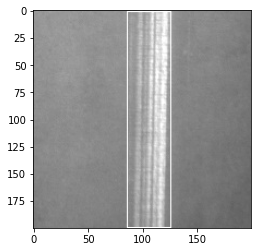

In [14]:
# show an example
annotation_file = random.choice(list(Path('dataset/labels').glob('*.txt')))
with open(annotation_file, 'r') as file:
    annotation_list = file.read().split('\n')[:-1]
    annotation_list = [_.split() for _ in annotation_list]
    annotation_list = [[float(_) for _ in __] for __ in annotation_list]

image = Image.open(str(annotation_file).replace('labels', 'images').replace('txt', 'jpg'))
plot_bbox(image, annotation_list)

## Preparing training, validation, test dataset

In [15]:
annotations = [str(_) for _ in Path('dataset/labels').glob('*.txt')]
images = [_.replace('labels', 'images').replace('txt', 'jpg') for _ in annotations]

train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size=0.3, random_state=42)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size=0.5, random_state=42)

In [16]:
!mkdir dataset/images/train dataset/images/val dataset/images/test dataset/labels/train dataset/labels/val dataset/labels/test

In [17]:
def move_files_to_folder(file_list, destination_folder):
    for f in file_list:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

move_files_to_folder(train_images, 'dataset/images/train')
move_files_to_folder(val_images, 'dataset/images/val')
move_files_to_folder(test_images, 'dataset/images/test')
move_files_to_folder(train_annotations, 'dataset/labels/train')
move_files_to_folder(val_annotations, 'dataset/labels/val')
move_files_to_folder(test_annotations, 'dataset/labels/test')

In [18]:
with open('yolov5/data/surface_defect_data.yaml', 'w') as f:
    f.write(f"\
train: ../dataset/images/train/\n\
val: ../dataset/images/val/\n\
test: ../dataset/images/test/\n\
\n\
# number of classes\n\
nc: 6\n\
\n\
# class names \n\
names: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']\
")

## Training Yolov5

In [ ]:
# %cd yolov5
!python train.py --img 640 --cfg yolov5x.yaml --batch 16 --epochs 40 --data surface_defect_data.yaml --weights yolov5x.pt --workers 24 --name yolo_surface_defect --cache
# continue training: --weights runs/train/yolo_surface_defect/weights/best.pt
# %cd ..

train: weights=yolov5x.pt, cfg=yolov5x.yaml, data=surface_defect_data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=40, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=runs/train, name=yolo_surface_defect, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-21-ge6e36aa torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.

In [ ]:
# saved in telegram
!zip -r ../yolo_surface_defect2.zip /content/yolov5/runs/train/yolo_surface_defect2

In [ ]:
!python detect.py --source ../dataset/images/test/ --weights runs/train/yolo_surface_defect2/weights/best.pt --conf 0.25 --name yolo_surface_defect

detect: weights=['runs/train/yolo_surface_defect2/weights/best.pt'], source=../dataset/images/test/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_surface_defect, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-21-ge6e36aa torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model Summary: 444 layers, 86207059 parameters, 0 gradients
image 1/270 /content/dataset/images/test/crazing_106.jpg: 640x640 3 crazings, Done. (0.093s)
image 2/270 /content/dataset/images/test/crazing_109.jpg: 640x640 2 crazings, Done. (0.072s)
image 3/270 /content/dataset/images/test/crazing_11.jpg: 640x640 1 crazing, Done. (0.053s)
image 4/270 /content/dataset/images/test/crazing_114.jpg: 640x640 2 crazi

In [5]:
# tf.keras.utils.get_file(origin='https://highspeed-movies1.herokuapp.com/87689/yolov5.zip?hash=AgADDA', extract=True, cache_dir='.', cache_subdir='./saved_model')

327016448/327001193 [==============================] - 620s 2us/step


'././saved_model/yolov5.zip'

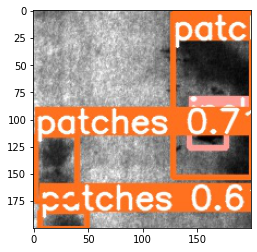

In [ ]:
detection_dir = 'runs/detect/yolo_surface_defect'

random_test_image = Image.open(random.choice(list(Path(detection_dir).glob('*'))))
plt.imshow(random_test_image)

In [ ]:
!python val.py --weights runs/train/yolo_surface_defect2/weights/best.pt --data surface_defect_data.yaml --task test --name yolo_surface_defect

val: data=/content/yolov5/data/surface_defect_data.yaml, weights=['runs/train/yolo_surface_defect2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=yolo_surface_defect, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-21-ge6e36aa torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model Summary: 444 layers, 86207059 parameters, 0 gradients
test: Scanning '/content/yolov5/../dataset/labels/test' images and labels...270 found, 0 missing, 0 empty, 0 corrupt: 100% 270/270 [00:00<00:00, 744.22it/s]
test: New cache created: /content/yolov5/../dataset/labels/test.cache
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 9/9 [00:16<00:00,  1.82s/it]
                 all        270        653      0.681      0.737      0.738      0.402
     